In [3]:
# imports
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.preprocessing import OneHotEncoder
import math 
import random 
from random import random
from scipy.ndimage.interpolation import rotate

In [12]:
class Network:
    
    def __init__(self, m, k, d, num_layer, lam, jitter, drop_prob):
        self.m_nodes = m
        self.d_dim = d
        self.K = k
        self.lam = lam
        self.X_images_train = None
        self.Y_onehot_train = None
        self.y_labels_train = None
        self.X_images_validate = None
        self.Y_onehot_validate = None
        self.y_labels_validate = None
        self.X_images_test = None
        self.Y_onehot_test = None
        self.y_labels_test = None
        self.W =  [None] * num_layer
        self.b =  [None] * num_layer
        
        # flags to configure
        self.jitter = jitter
        
        # dropout
        self.drop_prob = drop_prob

    
    def loadBatch(self,filename):
        matdata = sio.loadmat(filename)
        X_images = np.matrix(matdata['data']).astype(float)
        y_labels = np.array(matdata['labels'])
        onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
        Y_onehot = onehot_encoder.fit_transform(y_labels).astype(int)
        return X_images.T, Y_onehot.T, y_labels.T  # convert to (dxn)
    
    def setData(self, filename_train, filename_validate, filename_test):
        if filename_train != None:
            self.X_images_train, self.Y_onehot_train, self.y_labels_train =  self.loadBatch(filename_train)
            self.d_dim = self.X_images_train.shape[0]
        if filename_validate != None:
            self.X_images_validate, self.Y_onehot_validate, self.y_labels_validate =  self.loadBatch(filename_validate)
        if filename_test != None:
            self.X_images_test, self.Y_onehot_test, self.y_labels_test =  self.loadBatch(filename_test)
            
    def setMoreData(self, numbers_train, train_size, filename_test):
        for setnum in range(numbers_train):
            path = 'Dataset/cifar-10-batches-mat/data_batch_'+str(setnum+1)+'.mat'
            (X_images_current,Y_onehot_current,y_labels_current)= self.loadBatch(path)
            if setnum == 0:
                X_images_all = X_images_current
                Y_onehot_all = Y_onehot_current
                y_labels_all = y_labels_current
            else:
                X_images_all = np.append(X_images_all, X_images_current, 1)
                Y_onehot_all = np.append(Y_onehot_all, Y_onehot_current, 1)
                y_labels_all = np.append(y_labels_all, y_labels_current, 1)
        # split into train and validate
        self.X_images_train = X_images_all[:, 0:train_size]
        self.X_images_validate = X_images_all[:, train_size:]
        self.Y_onehot_train = Y_onehot_all[:, 0:train_size]
        self.Y_onehot_validate = Y_onehot_all[:, train_size:]
        self.y_labels_train = y_labels_all[:, 0:train_size]
        self.y_labels_validate = y_labels_all[:, train_size:]
        self.X_images_test, self.Y_onehot_test, self.y_labels_test = self.loadBatch('Dataset/cifar-10-batches-mat/test_batch.mat')
            
    def standardize(self, X):
        mean_X = X.mean(axis=1)
        std_X = X.std(axis=1) 
        return (X - mean_X) / std_X

    def initialize(self, key, mean, std, w_dim, w_num, b_dim):
        np.random.seed(0)
        self.W[key] = np.random.normal(mean, std, (w_dim, w_num))
        self.b[key] = np.zeros((b_dim, 1))
        
    def evaluateClassifier(self, X, W, b):        
        S1 = np.dot(W[0],X)+b[0]
        H = self.relu(S1)
        H = self.dropout(H)
        S2 = np.dot(W[1],H)+b[1]
        P = self.softmax(S2)
        return P, H

    def relu(self, X):
        return np.maximum(0,X)
        
    def softmax(self,scores):
        return np.exp(scores)/np.sum(np.exp(scores), axis=0)
    
    def computeCost(self, X, Y, W, b):  
        loss = np.sum(self.lossCrossEntropy(X, Y, W, b))/X.shape[1] 
        sum_W = 0
        sum_W +=  np.sum([np.sum(np.square(W[i])) for i in range(len(W))]) 
        regularization = self.lam * sum_W
        J =  loss + regularization 
        return J, loss
    
    def lossCrossEntropy(self, X, Y, W, b):
        P, _ = self.evaluateClassifier(X, W, b)
        Y = np.reshape(Y, (P.shape))
        #loss = - np.log(np.multiply(Y, P).sum(axis=0))
        loss = - np.sum(np.multiply(Y,np.log(P))) # check this:  - np.sum(Y*np.log(P))
        return loss
    
    def computeGradients(self, X_batch, Y, W, b):
        N = X_batch.shape[1]
        grad_W =  [None] * len(W)
        grad_b =  [None] * len(b)
        
        # forward pass
        P, H = self.evaluateClassifier(X_batch, W, b)
        Y = np.reshape(Y, ( P.shape))
        
        # backward pass
        G_batch = -(Y-P) #(10, 10000)
        ones =  np.full((N,1), 1)
        
        grad_W[1] =  1/N * G_batch * H.T + 2 * self.lam * W[1] #(10,50) 
        grad_b[1] = 1/N * G_batch * ones # (10x1)
        
        G_batch = W[1].T * G_batch #(50,10000)
        G_batch = np.multiply(G_batch, np.where(H > 0, 1, 0))
        
        grad_W[0] = 1/N * G_batch * X_batch.T + 2 * self.lam * W[0]
        grad_b[0] = 1/N * G_batch * ones
        return grad_W, grad_b
                 
        
    def computeGradsNumSlow(self, X, Y, W, b, h):
        """ Converted from matlab code """
        grad_W =  [None] * len(W)
        grad_b =  [None] * len(b)

        for j in range(len(b)):
            grad_b[j] = np.zeros(b[j].shape)
            for i in range(b[j].shape[0]):
                #b_try = np.array(b)
                b_try = b.copy()
                b_try[j][i] -= h
                c1, _ = self.computeCost(X, Y, W, b_try)
                
                #b_try = b.copy() 
                #b_try = deepcopy(b)
                b_try[j][i] += 2*h
                c2, _ = self.computeCost(X, Y, W, b_try)
                
                grad_b[j][i] = (c2-c1) / (2*h)
                
                b_try[j][i] -= h  #restore variable

            
        for j in range(len(W)):
            grad_W[j] = np.zeros(W[j].shape)
            for i in range(W[j].shape[0]):
                for k in range (W[j].shape[1]):
                    W_try = W.copy()
                    W_try[j][i,k] -= h
                    c1, _ = self.computeCost(X, Y, W_try, b)
                    
                    #W_try = W.copy()
                    #W_try = deepcopy(W)
                    W_try[j][i,k] += 2*h
                    c2, _ = self.computeCost(X, Y, W_try, b)
                    grad_W[j][i,k] = (c2-c1) / (2*h)
                    
                    W_try[j][i,k] -= h # restore
                    
        return grad_W, grad_b
    
    def computeRelativeError(self, ga ,gn ,eps):
        return np.absolute(np.subtract(ga, gn))/np.maximum(np.add(np.absolute(ga), np.absolute(gn)), np.full(ga.shape, eps))
    
    def computeAccuracy(self, X, y, W, b):
        P, _ = self.evaluateClassifier(X,W,b)
        pred = np.argmax(P, axis=0)
        acc =  np.count_nonzero(pred == y) / X[1].size
        return acc
    
    def generateMiniBatches(self, n_batch, X, Y, permute):
        n = X[1].size 
        X_batches = []
        Y_batches = []
        if permute:
            #X_sh, Y_sh = shuffle(X.T, Y.T) #causes memory error
            shuff_indx = np.random.permutation(X.shape[1])
            X = X[:, shuff_indx]
            Y = Y[:, shuff_indx]
        for j in range(int(n/n_batch)):
            j_start = j*n_batch 
            j_end = (j+1)*n_batch 

            X_batch = X[:, j_start:j_end]
            Y_batch = Y[:, j_start:j_end]
            
            X_batches.append(X_batch)
            Y_batches.append(Y_batch)

        return X_batches, Y_batches
    
    # Bonus 1 e: modified from https://srome.github.io/Jitter,-Convolutional-Neural-Networks,-and-a-Kaggle-Framework/
    def augment(self, temp):
        if np.random.random() > .7:
            temp[np.random.randint(0,32,1), :, :] = 0
        if np.random.random() > .7:
            temp[:, np.random.randint(0,32,1), :] = 0
        if np.random.random() > .7:
            temp = rotate(temp, np.random.randint(-20,20),axes=(0,1), reshape=False)
        return temp

    # Bonus 1 c: modified from https://gluon.mxnet.io/chapter03_deep-neural-networks/mlp-dropout-scratch.html + https://d2l.ai/chapter_multilayer-perceptrons/dropout.html
    def dropout(self, X):
        assert 0 <= self.drop_prob <= 1
        keep_prob = 1 - self.drop_prob
        mask = np.random.uniform(0, 1.0, X.shape) < keep_prob
        if keep_prob > 0.0: # avoiding division by zero
            scale = (1/keep_prob)
        return (np.multiply(mask, X) * scale)
    

    def miniBatchGD(self, X, Y, y, X_validate, Y_validate, y_validate, W, b, n_batch, eta_min, eta_max, n_epochs, permute, ns, cycle):
        costs_train = []
        losses_train = []
        accs_train = []
        costs_validate = []
        losses_validate= []
        accs_validate  = []
        etas = []
        etas_acc = []

        # compute cost -> print and save it  
        cost_train, loss_train =self.computeCost(X, Y, W, b)
        costs_train.append(cost_train)
        losses_train.append(loss_train)
        cost_validate, loss_validate =self.computeCost(X_validate, Y_validate, W, b)
        costs_validate.append(cost_validate)
        losses_validate.append(loss_validate)

        # compute acc -> print and save it 
        accs_train.append(self.computeAccuracy(X, y, W, b))
        acc_validate = self.computeAccuracy(X_validate, y_validate, W, b)
        accs_validate.append(acc_validate)

        # assignment 1: bonus 1b
        acc_best = acc_validate
        n_best = 0
        W_best = W
        
        # assignment 2 CLR
        t = 0
        eta_t = eta_min
        etas.append(eta_t)
        etas_acc.append(acc_validate)

        if not permute:
            X_batches, Y_batches = self.generateMiniBatches(n_batch, X, Y, permute)
        for epoch in range(n_epochs): #iterate over epoch
            if permute:  # shuffle training data for every epoch
                X_batches, Y_batches = self.generateMiniBatches(n_batch, X, Y, permute)
        
            
            for idx, X_batch in enumerate(X_batches, start=0):   # iterate over mini-batches
                Y_batch = Y_batches[idx]
                #print(X_batch.shape) #(3072x100)
                
                if self.jitter and epoch > 0: # apply jitter
                    X_batch_jit = np.array(X_batch.T)
                    for img in range(X_batch_jit.shape[0]):
                        im =  np.transpose(X_batch_jit[img, :].reshape((3, 32,32)) , (1,2,0))# reshape images and transpose to (32,32,3)
                        im_aug = np.transpose(self.augment(im), (2,0,1)).reshape((3072)) #transpose back (3, 32,32) and reshape (3072)                   
                        X_batch_jit[img]=im_aug
                    X_batch_new = np.asmatrix(X_batch_jit.T)
                    #print("shape x batch", X_batch_new.shape, X_batch.shape)
                    
                if cycle:
                    if t == 0: # first cycle
                        l = 0
                        eta_t = eta_min
                    elif t % (2*ns) == 0: # next cycle
                        l += 1

                    if t >= (2*l*ns) and t <= (2*l+1)*ns:
                        eta_t = eta_min + (t-2*l*ns)/ns * (eta_max-eta_min)
                        #print("increase", (t-2*l*ns)/ns * (eta_max-eta_min))
                    elif t >= (2*l+1)*ns and t <= 2*(l+1)*ns:
                        eta_t = eta_max - (t-(2*l+1)*ns)/ns * (eta_max-eta_min)
                        #print("dcrease", t)

                         
                # compute gradients for batch
                if self.jitter and epoch > 0:
                    grad_W_ana, grad_b_ana = self.computeGradients(X_batch_new, Y_batch, W,b) 
                else:
                    grad_W_ana, grad_b_ana = self.computeGradients(X_batch, Y_batch, W,b) 
                    # adjust W,b by eta
                for i in range(len(W)):
                    W[i] -= eta_t*grad_W_ana[i]
                    b[i] -= eta_t*grad_b_ana[i]
                    
                # save eta for plotting in range test
                
                if t % len(X_batches)/5 == 0:
                    etas.append(eta_t)   
                    etas_acc.append(self.computeAccuracy(X_validate, y_validate, W, b))
                
                t += 1
                
            # save eta for plotting
            #etas.append(eta_t)    
            cost_train, loss_train =self.computeCost(X, Y, W, b)
            costs_train.append(cost_train)
            losses_train.append(loss_train)
            cost_validate, loss_validate =self.computeCost(X_validate, Y_validate, W, b)
            costs_validate.append(cost_validate)
            losses_validate.append(loss_validate)

            acc_train = self.computeAccuracy(X, y, W, b)
            accs_train.append(acc_train)
            acc_validate = self.computeAccuracy(X_validate, y_validate, W, b)
            accs_validate.append(acc_validate)

            print("epoch {0} \n cost_train: {1} \n cost_validate: {2} \n accuracy_train: {3} \n accuracy_validate: {4} \n".format(epoch, cost_train, cost_validate, acc_train, acc_validate))

            if acc_validate > acc_best: # bonus 1b
                W_best = W.copy()
                n_best = epoch
                acc_best = acc_validate
        # return addionally etas_acc for the range test
        return costs_train, losses_train, accs_train, costs_validate, losses_validate, accs_validate, W, W_best, n_best, etas, etas_acc


In [8]:
# plotting 
# Pictures 1x10
def plotPictures(trained_Weight, safeto, row, col, save=False):
    s_im =[]
    for label in range(trained_Weight.shape[0]):
        im =  np.transpose(np.reshape(trained_Weight[label, :], (3, 32,32)), (1,2,0))
        im = (im - im.min()) / (im.max() - im.min())
        s_im.append(im)

    fig = plt.figure(figsize=(10., 10.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(row, col),  # creates 1x10 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, s_im):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
    if save:
        plt.savefig(safeto)
    plt.show()

# plot all graphs
def plotResults(costs_train, losses_train, accs_train, costs_validate, losses_validate, accs_validate, safeto, save=False):
    # plotting costs
    plt.plot(costs_train, label = "training")
    plt.plot(costs_validate, label = "validation")
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.suptitle('Cost')
    plt.legend()
    if save:
        plt.savefig('Result_Pics/'+safeto+'cost.png')
    plt.show()  
    
    plt.plot(losses_train, label = "training")
    plt.plot(losses_validate, label = "validation")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.suptitle('Loss')
    plt.legend()
    if save:
        plt.savefig('Result_Pics/'+safeto+'loss.png')
    plt.show()  
    
    # plotting accuracy
    plt.plot(accs_train, label = 'training')
    plt.plot(accs_validate, label = 'validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.suptitle('Accuracy')
    plt.legend()
    if save:
        plt.savefig('Result_Pics/'+safeto+'acc.png')
    plt.show()

epoch 0 
 cost_train: 1.547769118693413 
 cost_validate: 1.5997060421646299 
 accuracy_train: 0.4589591836734694 
 accuracy_validate: 0.454 

epoch 1 
 cost_train: 1.5906990850771545 
 cost_validate: 1.6563943946034014 
 accuracy_train: 0.44185714285714284 
 accuracy_validate: 0.437 

epoch 2 
 cost_train: 1.2579295090461229 
 cost_validate: 1.391984669031849 
 accuracy_train: 0.5657142857142857 
 accuracy_validate: 0.531 

epoch 3 
 cost_train: 1.1032377770947581 
 cost_validate: 1.2841968588985415 
 accuracy_train: 0.6279795918367347 
 accuracy_validate: 0.547 

epoch 4 
 cost_train: 1.1824916868653015 
 cost_validate: 1.389178326703781 
 accuracy_train: 0.592530612244898 
 accuracy_validate: 0.525 

epoch 5 
 cost_train: 1.6937469568304027 
 cost_validate: 1.8966260561732602 
 accuracy_train: 0.45357142857142857 
 accuracy_validate: 0.415 

epoch 6 
 cost_train: 1.0967267588718987 
 cost_validate: 1.3776752409908068 
 accuracy_train: 0.6230408163265306 
 accuracy_validate: 0.527 

e

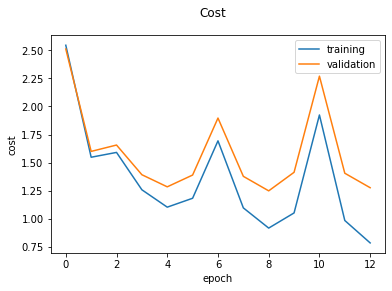

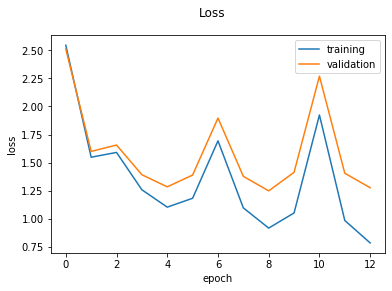

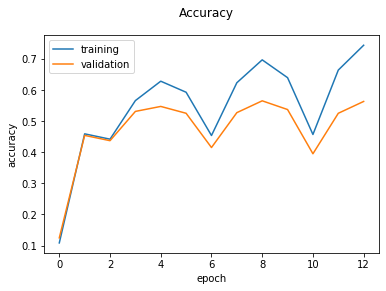

acc test 0.5514


In [10]:
# Bonus 1
# b) explore whether having more hidden nodes improves the final classification rate
# train with a good parameter found before
# initialize the network
m = 300
k = 10
d = 3072
num_layer = 2
lam = 0
jitter = False
drop_prob = 0

# 3 Train your network with cyclical learning rates
eta_min = 1e-5
eta_max = 1e-1
n_batches = 100 # batch size

setup = "bonus1b_m300_lambda0"

net = Network(m,k,d, num_layer, lam, jitter, drop_prob)
# load the data
net.setMoreData( 5, 49000, 'Dataset/cifar-10-batches-mat/test_batch.mat')
# standardize X values
net.X_images_train = net.standardize(net.X_images_train)
net.X_images_validate = net.standardize(net.X_images_validate)
net.X_images_test = net.standardize(net.X_images_test)

# matrix W1 and W2 have size m x d and K x m respectively and the vectors b1 and b2 have sizes m x 1 and K x 1.
net.initialize(0, 0, 1/math.sqrt(net.d_dim), net.m_nodes, net.d_dim, net.m_nodes)
net.initialize(1, 0, 1/math.sqrt(net.m_nodes), net.K, net.m_nodes, net.K)

ns = 2* math.floor(net.X_images_train.shape[1]/n_batches) # stepsize
epochs = 12

#print("lambda ", net.lam, "ns ", ns, "epochs ", epochs)
costs_train,losses_train, accs_train, costs_validate, losses_validate, accs_validate, W_trained, W_best, n_best, etas = net.miniBatchGD( net.X_images_train, net.Y_onehot_train, net.y_labels_train,
                                                net.X_images_validate, net.Y_onehot_validate, net.y_labels_validate, 
                                                net.W, net.b, n_batches, eta_min, eta_max, epochs, False, ns, True)

plotResults(costs_train, losses_train, accs_train, costs_validate, losses_validate, accs_validate, setup, True)
print("acc test",net.computeAccuracy(net.X_images_test, net.y_labels_test,  W_trained, net.b))

In [ ]:
# 1e) Apply jitter
# Bonus 1
# initialize the network
m = 50
k = 10
d = 3072
num_layer = 2
lam = 0
jitter = True
drop_prob = 0

# 3 Train your network with cyclical learning rates
eta_min = 1e-5
eta_max = 1e-1
n_batches = 100 # batch size
#cycles = 1

setup = "bonus1e_jitter_alldata"

net = Network(m,k,d, num_layer, lam, jitter, drop_prob)
# load the data
net.setMoreData( 5, 45000, 'Dataset/cifar-10-batches-mat/test_batch.mat')
'''net.setData('Dataset/cifar-10-batches-mat/data_batch_1.mat',
            'Dataset/cifar-10-batches-mat/data_batch_2.mat', 
            'Dataset/cifar-10-batches-mat/test_batch.mat')'''
# standardize X values
net.X_images_train = net.standardize(net.X_images_train)
net.X_images_validate = net.standardize(net.X_images_validate)
net.X_images_test = net.standardize(net.X_images_test)

# matrix W1 and W2 have size m x d and K x m respectively and the vectors b1 and b2 have sizes m x 1 and K x 1.
net.initialize(0, 0, 1/math.sqrt(net.d_dim), net.m_nodes, net.d_dim, net.m_nodes)
net.initialize(1, 0, 1/math.sqrt(net.m_nodes), net.K, net.m_nodes, net.K)

ns = 2* math.floor(net.X_images_train.shape[1]/n_batches) # stepsize
epochs = 12

print("lambda ", net.lam, "ns ", ns, "epochs ", epochs)
costs_train,losses_train, accs_train, costs_validate, losses_validate, accs_validate, W_trained, W_best, n_best, etas = net.miniBatchGD( net.X_images_train, net.Y_onehot_train, net.y_labels_train,
                                                net.X_images_validate, net.Y_onehot_validate, net.y_labels_validate, 
                                                net.W, net.b, n_batches, eta_min, eta_max, epochs, False, ns, True)

plotResults(costs_train, losses_train, accs_train, costs_validate, losses_validate, accs_validate, setup, True)
print("acc test",net.computeAccuracy(net.X_images_test, net.y_labels_test,  W_trained, net.b))


In [ ]:
# 1c) Dropout

# initialize the network
m = 300
k = 10
d = 3072
num_layer = 2
lam = 0
jitter = False
drop_prob = 0.2

# 3 Train your network with cyclical learning rates
eta_min = 1e-5
eta_max = 1e-1
n_batches = 100 # batch size

setup = "bonus1c_m300_d02_all"

net = Network(m,k,d, num_layer, lam, jitter, drop_prob)
# load the data
net.setMoreData( 5, 45000, 'Dataset/cifar-10-batches-mat/test_batch.mat')

# standardize X values
net.X_images_train = net.standardize(net.X_images_train)
net.X_images_validate = net.standardize(net.X_images_validate)
net.X_images_test = net.standardize(net.X_images_test)

# matrix W1 and W2 have size m x d and K x m respectively and the vectors b1 and b2 have sizes m x 1 and K x 1.
net.initialize(0, 0, 1/math.sqrt(net.d_dim), net.m_nodes, net.d_dim, net.m_nodes)
net.initialize(1, 0, 1/math.sqrt(net.m_nodes), net.K, net.m_nodes, net.K)

ns = 2* math.floor(net.X_images_train.shape[1]/n_batches) # stepsize
epochs = 20

# Training
costs_train,losses_train, accs_train, costs_validate, losses_validate, accs_validate, W_trained, W_best, n_best, etas = net.miniBatchGD( net.X_images_train, net.Y_onehot_train, net.y_labels_train,
                                                net.X_images_validate, net.Y_onehot_validate, net.y_labels_validate, 
                                                net.W, net.b, n_batches, eta_min, eta_max, epochs, False, ns, True)

plotResults(costs_train, losses_train, accs_train, costs_validate, losses_validate, accs_validate, setup, True)

# Testing
net.drop_prob = 0 # turn off dropout for testing! 
print("acc test",net.computeAccuracy(net.X_images_test, net.y_labels_test,  W_trained, net.b))
print("acc validate",net.computeAccuracy(net.X_images_validate, net.y_labels_validate,  W_trained, net.b))


In [17]:
# Bonus 1: best accuracy
# initialize the network
m = 300
k = 10
d = 3072
num_layer = 2
lam = 0.0033892965614371645
jitter = True
drop_prob = 0

# 3 Train your network with cyclical learning rates
eta_min = 1e-5
eta_max = 1e-1
n_batches = 100 # batch size

setup = "bonus1best2_range2"

net = Network(m,k,d, num_layer, lam, jitter, drop_prob)
# load the data
net.setMoreData( 5, 45000, 'Dataset/cifar-10-batches-mat/test_batch.mat')
'''net.setData('Dataset/cifar-10-batches-mat/data_batch_1.mat',
            'Dataset/cifar-10-batches-mat/data_batch_2.mat', 
            'Dataset/cifar-10-batches-mat/test_batch.mat')'''
# standardize X values
net.X_images_train = net.standardize(net.X_images_train)
net.X_images_validate = net.standardize(net.X_images_validate)
net.X_images_test = net.standardize(net.X_images_test)

# matrix W1 and W2 have size m x d and K x m respectively and the vectors b1 and b2 have sizes m x 1 and K x 1.
net.initialize(0, 0, 1/math.sqrt(net.d_dim), net.m_nodes, net.d_dim, net.m_nodes)
net.initialize(1, 0, 1/math.sqrt(net.m_nodes), net.K, net.m_nodes, net.K)

ns = 2* math.floor(net.X_images_train.shape[1]/n_batches) # stepsize
epochs = 12

# Training
costs_train,losses_train, accs_train, costs_validate, losses_validate, accs_validate, W_trained, W_best, n_best, etas = net.miniBatchGD( net.X_images_train, net.Y_onehot_train, net.y_labels_train,
                                                net.X_images_validate, net.Y_onehot_validate, net.y_labels_validate, 
                                                net.W, net.b, n_batches, eta_min, eta_max, epochs, False, ns, True)

plotResults(costs_train, losses_train, accs_train, costs_validate, losses_validate, accs_validate, setup, True)

# Testing
net.drop_prob = 0 # turn off dropout for testing! 
print("acc test",net.computeAccuracy(net.X_images_test, net.y_labels_test,  W_trained, net.b))
print("acc validate",net.computeAccuracy(net.X_images_validate, net.y_labels_validate,  W_trained, net.b))


epoch 0 
 cost_train: 2.4844402101993457 
 cost_validate: 2.5331170239611667 
 accuracy_train: 0.4452888888888889 
 accuracy_validate: 0.4378 

epoch 1 
 cost_train: 2.1649956584530403 
 cost_validate: 2.2206936764568184 
 accuracy_train: 0.4466888888888889 
 accuracy_validate: 0.4198 



KeyboardInterrupt: 

epoch 0 
 cost_train: 2.8888368975614975 
 cost_validate: 2.950636475346607 
 accuracy_train: 0.3486 
 accuracy_validate: 0.322 

epoch 1 
 cost_train: 2.658323510860013 
 cost_validate: 2.7967502557496884 
 accuracy_train: 0.4255 
 accuracy_validate: 0.3776 

epoch 2 
 cost_train: 2.5055002675554263 
 cost_validate: 2.7139318667481045 
 accuracy_train: 0.4671 
 accuracy_validate: 0.3991 

epoch 3 
 cost_train: 2.3666676030436284 
 cost_validate: 2.637435182449313 
 accuracy_train: 0.5012 
 accuracy_validate: 0.4155 

epoch 4 
 cost_train: 2.2516935589966445 
 cost_validate: 2.576629718904661 
 accuracy_train: 0.5192 
 accuracy_validate: 0.4181 

epoch 5 
 cost_train: 2.1755769800630995 
 cost_validate: 2.5473799664538634 
 accuracy_train: 0.5238 
 accuracy_validate: 0.4125 

epoch 6 
 cost_train: 2.0869632268673675 
 cost_validate: 2.497333197503252 
 accuracy_train: 0.5386 
 accuracy_validate: 0.4139 

epoch 7 
 cost_train: 2.0496151090319987 
 cost_validate: 2.5005893510913273 
 acc

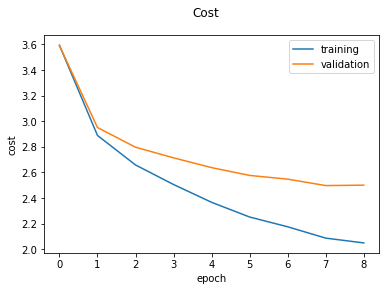

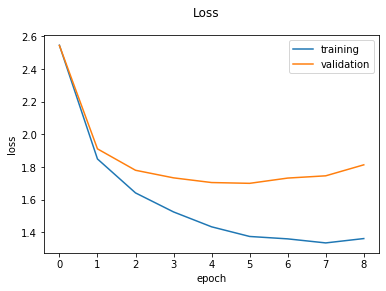

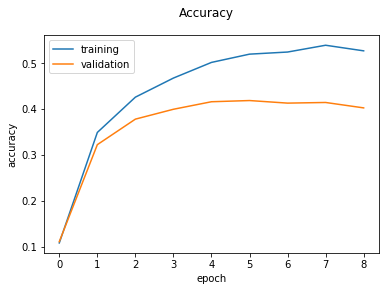

In [15]:
# Bonus 2: LR range test

# initialize the network
m = 300
k = 10
d = 3072
num_layer = 2
lam =  0.0033892965614371645
jitter = True
drop_prob = 0

net = Network(m,k,d, num_layer, lam, jitter, drop_prob)
# load the data
#net.setMoreData( 5, 45000, 'Dataset/cifar-10-batches-mat/test_batch.mat')
net.setData('Dataset/cifar-10-batches-mat/data_batch_1.mat',
            'Dataset/cifar-10-batches-mat/data_batch_2.mat', 
            'Dataset/cifar-10-batches-mat/test_batch.mat')
# standardize X values
net.X_images_train = net.standardize(net.X_images_train)
net.X_images_validate = net.standardize(net.X_images_validate)
net.X_images_test = net.standardize(net.X_images_test)

net.initialize(0, 0, 1/math.sqrt(net.d_dim), net.m_nodes, net.d_dim, net.m_nodes)
net.initialize(1, 0, 1/math.sqrt(net.m_nodes), net.K, net.m_nodes, net.K)

# 3 Train your network with cyclical learning rates
eta = 1e-5
eta_max = 0.1
n_batches = 100 # batch size
num_batches = net.X_images_train.shape[1]/n_batches
cycle = True

setup = "bonus2_mine"
epochs = 8
ns = epochs*num_batches

costs_train,losses_train, accs_train, costs_validate, losses_validate, accs_validate, W_trained, W_best, n_best, etas, etas_acc = net.miniBatchGD( net.X_images_train, net.Y_onehot_train, net.y_labels_train,
                                                net.X_images_validate, net.Y_onehot_validate, net.y_labels_validate, 
                                                net.W, net.b, n_batches, eta, eta_max, epochs, False, ns, cycle)
plotResults(costs_train, losses_train, accs_train, costs_validate, losses_validate, accs_validate, setup, True)

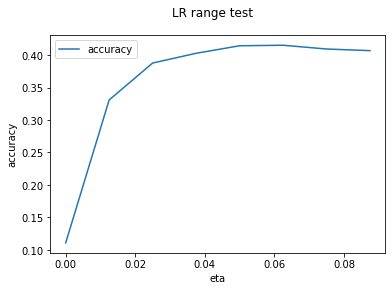

In [16]:
plt.plot( etas, etas_acc, label = "accuracy")
plt.xlabel('eta')
plt.ylabel('accuracy')
plt.suptitle('LR range test')
plt.legend()
plt.savefig('Result_Pics/bonus2_mine.png')
plt.show() 